This notebook is for creating the base ML model.

In [9]:
model_name = "holidays_weekends" + "_model_files"

In [23]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [11]:
module_path = os.path.abspath(os.path.join('../..', 'utils'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from ml_tools import add_weekends_holidays

d:\CS\summer_project\comp47360-group8\ml_pipeline\utils


In [12]:
df = pd.read_parquet('../../data_evaluation/taxi_trip_data/all_tlc_data_cleaned.parquet')
df.rename({'passenger_count':'busyness'},axis=1, inplace=True)
print(df.columns)

Index(['datetime', 'location', 'busyness'], dtype='object')


In [13]:
df.shape

(7319643, 3)

In [14]:
df.head()

,datetime,location,busyness
0,2021-01-01,3,132
1,2021-01-01,4,234
2,2021-01-01,5,19
3,2021-01-01,6,37
4,2021-01-01,7,493


In [15]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="location",
    timestamp_column="datetime"
)
print(data.head())

                    busyness
item_id timestamp           
3       2021-01-01       132
4       2021-01-01       234
5       2021-01-01        19
6       2021-01-01        37
7       2021-01-01       493


In [16]:
add_weekends_holidays(data)

In [19]:
data.head()

,,busyness,weekend,holiday
item_id,timestamp,,,
3,2021-01-01,132,0.0,1.0
4,2021-01-01,234,0.0,1.0
5,2021-01-01,19,0.0,1.0
6,2021-01-01,37,0.0,1.0
7,2021-01-01,493,0.0,1.0


In [20]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [21]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    eval_metric="MASE",
    prediction_length=prediction_length,
    path=model_name,
    known_covariates_names=['weekend', 'holiday']
)
print('we made the predictor')

we made the predictor


In [22]:
predictions = predictor.fit(train_data,
                                presets="medium_quality"
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'holidays_weekends_model_files'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       3.30 GB / 15.90 GB (20.8%)
Disk Space Avail:   2134.81 GB / 2794.50 GB (76.4%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': ['weekend', 'holiday'],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'busyness',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'h'.
Provided train_data has 6826363 rows 

In [24]:
print(predictor.leaderboard())

              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -1.137657     670.512556          90.138496          7
1     SeasonalNaive  -1.339581       1.097270           5.823288          2
2     DirectTabular  -1.790401      44.331763         182.343366          4
3  RecursiveTabular  -2.137651     568.698006         342.491430          3
4             Theta  -2.269781      51.699288           5.708947          6
5             Naive  -2.354159       4.686228           5.847390          1
6               ETS  -9.005625     211.566736           5.781912          5


In [25]:
future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=prediction_length, freq='H')
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = pd.DataFrame(index=future_index)
add_weekends_holidays(known_covariates)

c:\Users\Daniel\miniconda3\envs\comp47360_autogluon\lib\site-packages\autogluon\timeseries\utils\forecast.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


In [26]:
predictions = predictor.predict(train_data, known_covariates=known_covariates)
print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


                                   mean         0.1         0.2         0.3  \
item_id timestamp                                                             
3       2024-01-01 23:00:00  154.602215  121.258666  132.639517  140.850813   
        2024-01-02 00:00:00   95.870164   57.762124   70.836363   80.256779   
        2024-01-02 01:00:00  126.920473   85.145010   99.474527  109.788608   
        2024-01-02 02:00:00  115.840549   71.162034   86.487945   97.566830   
        2024-01-02 03:00:00   74.008308   26.477761   42.777565   54.554258   
...                                 ...         ...         ...         ...   
110     2022-04-23 13:00:00    1.196156  -12.616144   -7.875156   -4.453003   
        2022-04-23 14:00:00    1.197702  -12.616804   -7.873500   -4.449738   
        2022-04-23 15:00:00    1.206275  -12.612439   -7.866917   -4.444357   
        2022-04-23 16:00:00    1.199028  -12.622906   -7.873952   -4.451055   
        2022-04-23 17:00:00    1.218146  -12.619823 

data with frequency 'None' has been resampled to frequency 'h'.


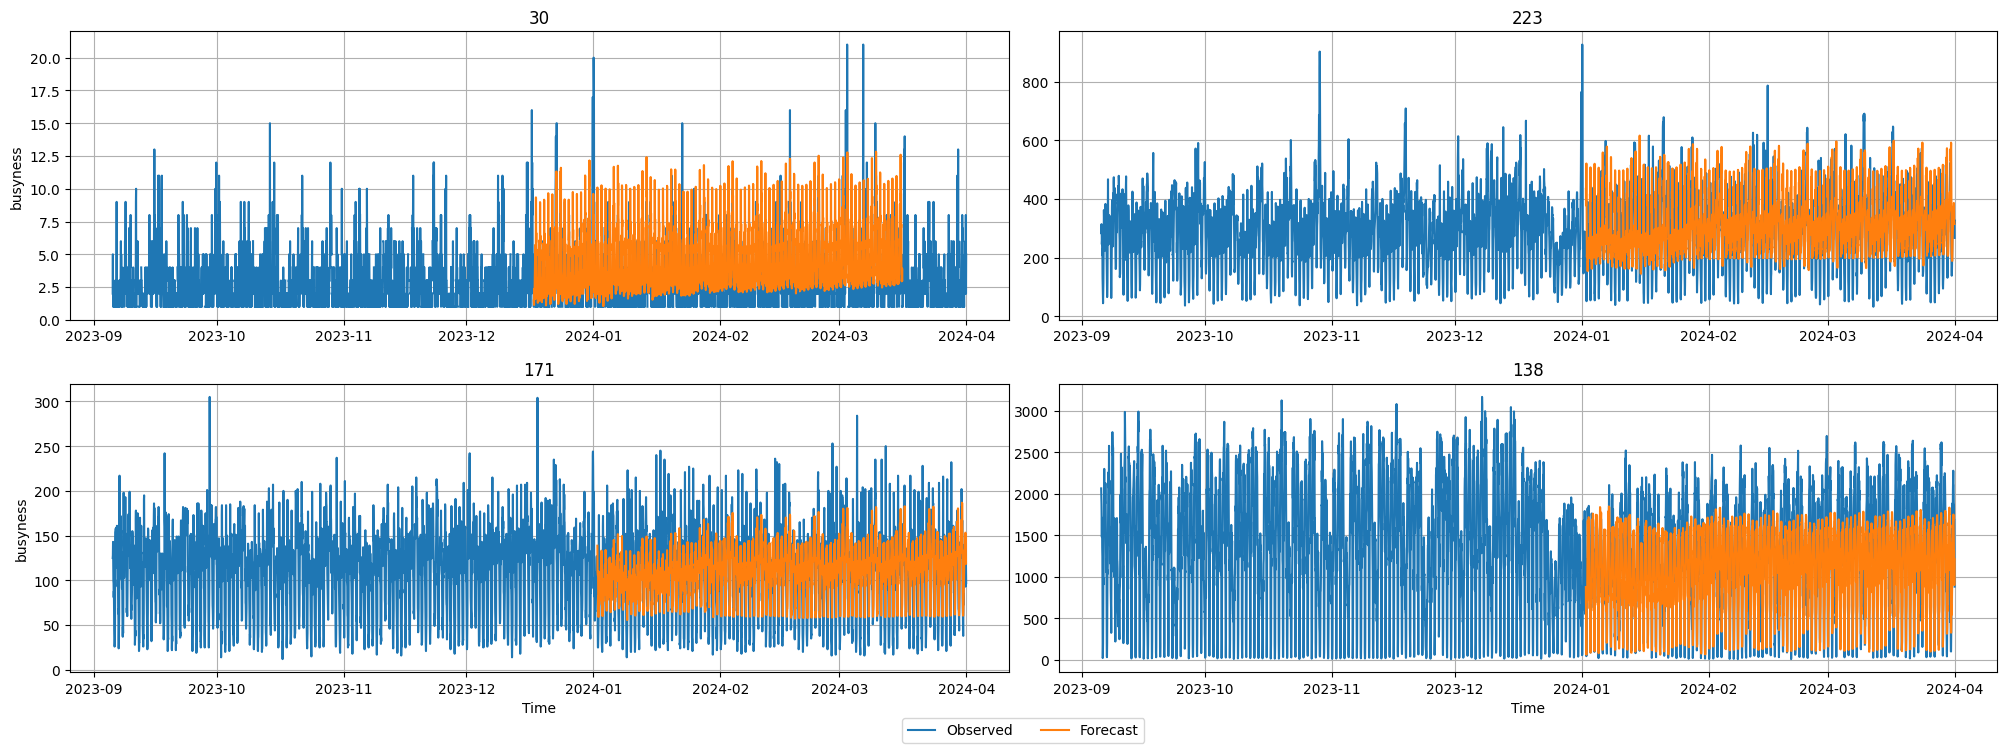

In [27]:
plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=4)


data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.


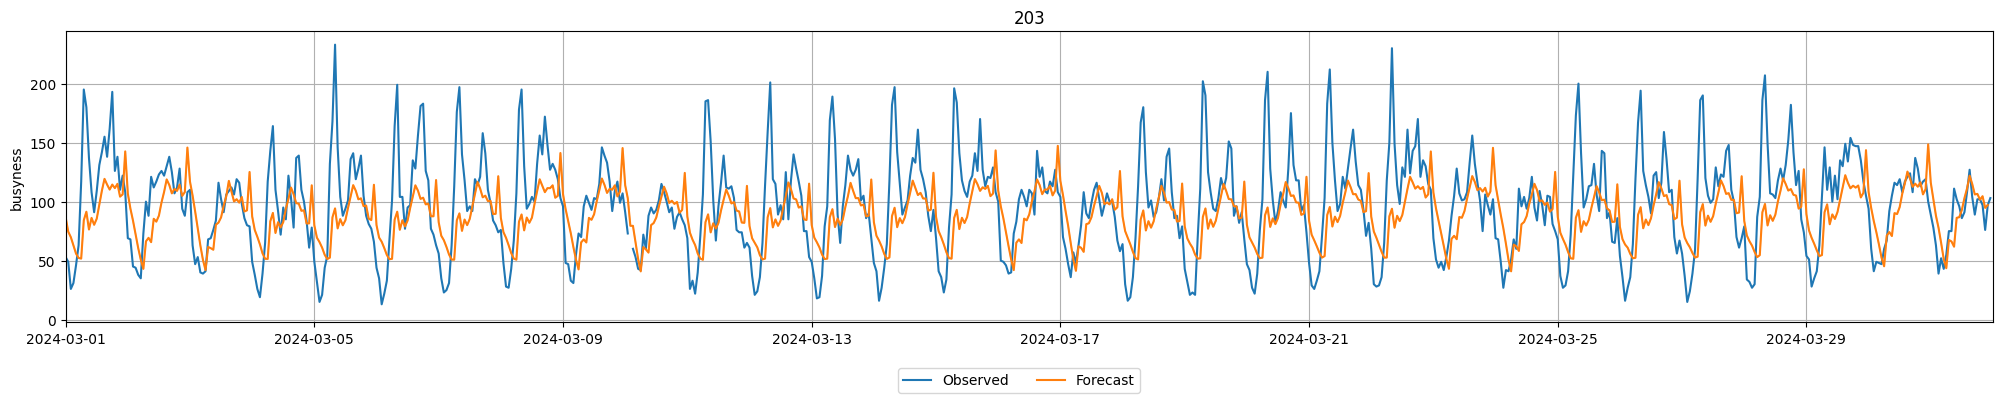

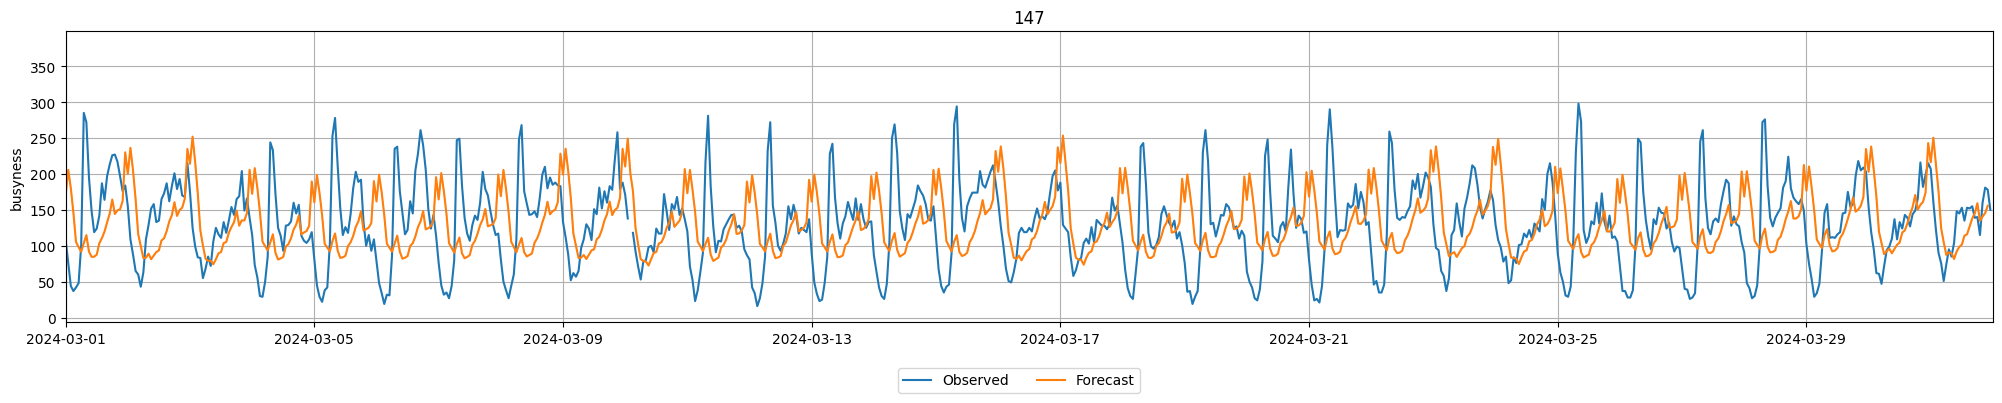

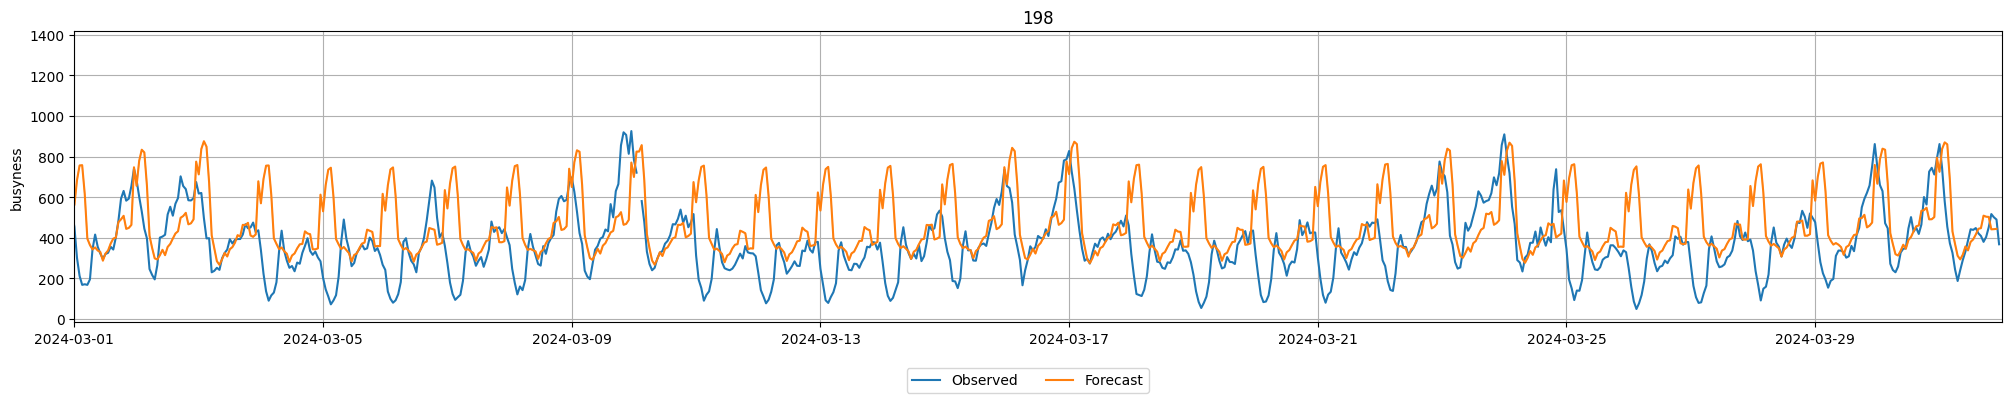

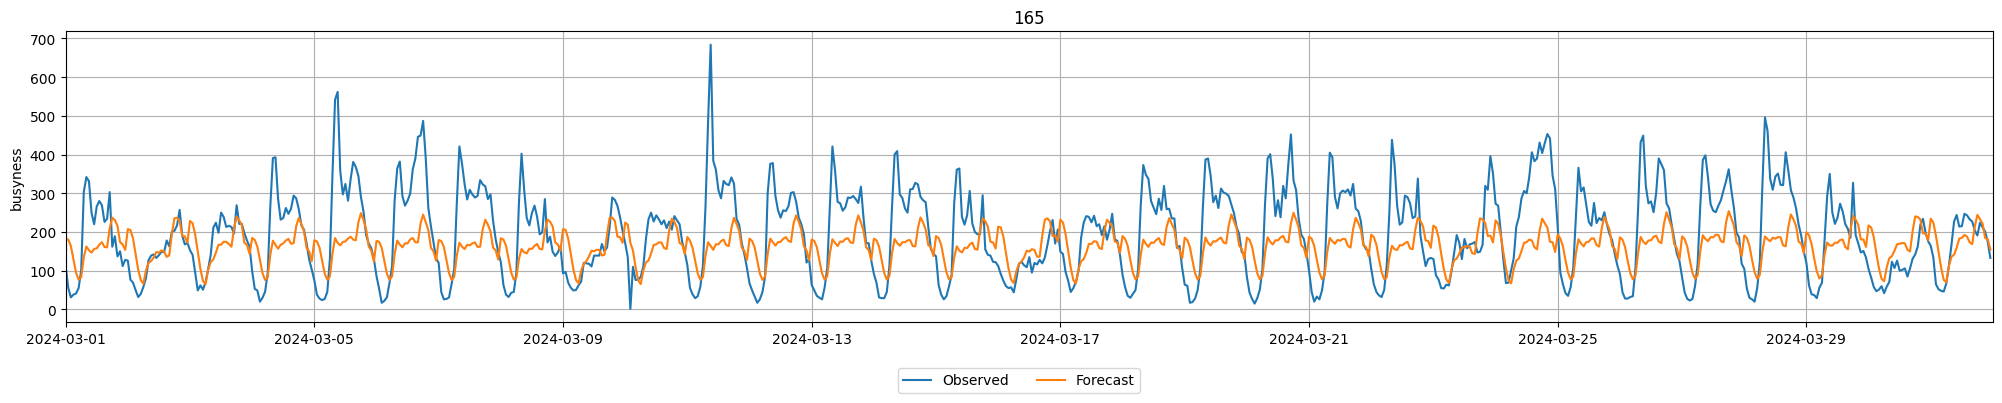

In [28]:
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
item_ids = [203, 147, 198, 165]
for id in item_ids:
    plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  item_ids=[id])
    ax = plot.gca()
    ax.set_xlim([xmin, xmax])
plt.show()

In [29]:
predictor.evaluate(test_data)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'MASE': -2.014370455838036}